In [2]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

Top-1 k-NN Acc: 100.00%
Top-2 k-NN Acc: 100.00%


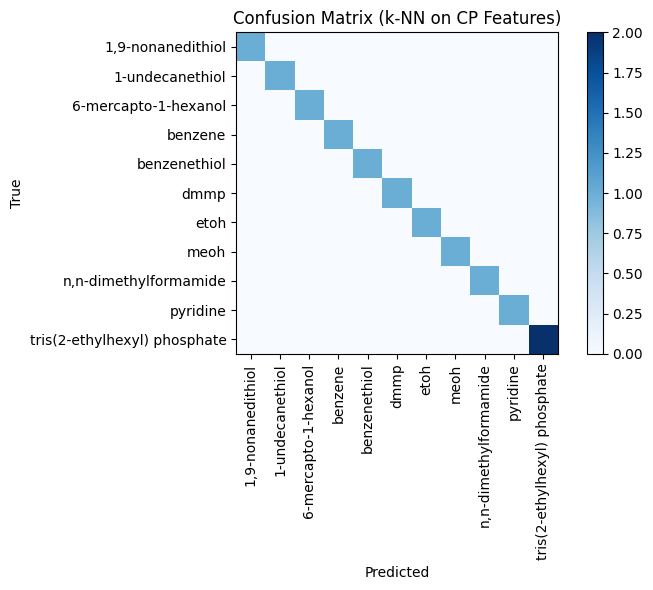

In [11]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from sklearn.preprocessing import minmax_scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Helper functions defined at top level ---
def baseline_als(y, lam=1e4, p=0.01, niter=10):
    L = len(y)
    D = np.diff(np.eye(L), 2); D = lam * D.dot(D.T)
    w = np.ones(L)
    for _ in range(niter):
        b = np.linalg.solve(np.diag(w) + D, w * y)
        w = p * (y > b) + (1 - p) * (y < b)
    return b

def preprocess(arr, lam=1e4, p=0.01, niter=10):
    out = np.zeros_like(arr)
    for i, s in enumerate(arr):
        b = baseline_als(s, lam=lam, p=p, niter=niter)
        c = s - b
        out[i] = c / np.linalg.norm(c) if np.linalg.norm(c) > 0 else c
    return out

def smooth(spec, K_smooth=3):
    kernel = np.ones(K_smooth) / K_smooth
    return np.convolve(spec, kernel, mode='same')

# --- Main pipeline function uses only the helpers above ---
def identify_with_knn(query_df, ref_df,
    crop_max=1500, lam=1e4, p=0.01, niter=10,
    K_smooth=3, N_peak=12, w_max=15,
    height=0.01, prominence=0.01,
    n_neighbors=3):

    # get wavenumber columns below crop_max
    wav_cols = query_df.columns[:-1]
    wavs     = pd.to_numeric(wav_cols)
    keep_cols = wav_cols[wavs < crop_max]

    # build raw matrices
    Q_raw  = query_df[keep_cols].values.astype(float)
    R_raw  = ref_df  [keep_cols].values.astype(float)
    labels = ref_df['Label'].values
    classes = np.unique(labels)

    # preprocess both sets
    Q = preprocess(Q_raw, lam, p, niter)
    R = preprocess(R_raw, lam, p, niter)

    # build CP indices per class
    CPs = {}
    for chem in classes:
        specs = R[labels == chem]
        counts = np.zeros(Q.shape[1], int)
        for s in specs:
            pks, _ = find_peaks(smooth(s, K_smooth),
                                height=height, prominence=prominence)
            counts[pks] += 1
        cp_idxs = np.argsort(counts)[-N_peak:]
        CPs[chem] = sorted(cp_idxs)

    # global CP union for fixed-length features
    global_cp = sorted({i for idxs in CPs.values() for i in idxs})

    # build reference feature matrix X, label vector y
    X_list, y_list = [], []
    for chem in classes:
        for s in R[labels == chem]:
            vec = [np.max(s[max(0, i - w_max//2):i + w_max//2 + 1])
                   for i in global_cp]
            X_list.append(minmax_scale(vec))
            y_list.append(chem)
    X = np.vstack(X_list)
    y = np.array(y_list)

    # train k-NN on CP-feature space
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='cosine')
    knn.fit(X, y)

    # build query features and predict
    Q_feat = np.vstack([
        minmax_scale([np.max(s[max(0, i - w_max//2):i + w_max//2 + 1])
                      for i in global_cp])
        for s in Q
    ])
    pred1 = knn.predict(Q_feat)
    neigh_idx = knn.kneighbors(Q_feat, n_neighbors=2, return_distance=False)
    pred2 = np.array([[y[idx] for idx in row] for row in neigh_idx])

    return pred1, pred2, knn, CPs

# ---- run & evaluate ----
ref_df   = pd.read_csv('Jesse_Dataset/reference.csv')
query_df = pd.read_csv('Jesse_Dataset/query.csv')

pred1, pred2, knn_model, CPs = identify_with_knn(query_df, ref_df)
true = query_df['Label'].values

acc1 = accuracy_score(true, pred1)
acc2 = np.mean([t in row for t,row in zip(true, pred2)])
print(f"Top-1 k-NN Acc: {acc1:.2%}")
print(f"Top-2 k-NN Acc: {acc2:.2%}")

# Confusion matrix
labels_unique = np.unique(true)
cm = confusion_matrix(true, pred1, labels=labels_unique)
plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.xticks(range(len(labels_unique)), labels_unique, rotation=90)
plt.yticks(range(len(labels_unique)), labels_unique)
plt.colorbar()
plt.title("Confusion Matrix (k-NN on CP Features)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
